# Optimize the set of samples for limited learning

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [29]:
class Const:
    """All constants collected together."""
    img_size = 28
    nclasses = 10
    ind = [1,77,5,50,20,0,13,15,41,4] # Optimized training indices
    
C = Const()

In [30]:
(xtrain,ytrain), (xtest,ytest) = tf.keras.datasets.mnist.load_data()

def scale_mnist(x):
    x  = x.astype('float32')/255
    x = np.expand_dims(x,3) # Weird extra axis for channels, to make keras work
    return x
    
xtrain = scale_mnist(xtrain)
xtest  = scale_mnist(xtest)

ytrain = tf.keras.utils.to_categorical(ytrain, C.nclasses)
ytest  = tf.keras.utils.to_categorical(ytest, C.nclasses)

In [31]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(C.img_size, C.img_size, 1)), # Universal input layer
        tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(5,5), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(C.nclasses, activation='softmax')
    ])
    
    model.compile(loss='categorical_crossentropy',
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=['accuracy'])
    
    return model

model = build_model()
#model.summary()

In [25]:
class PrintDot(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 10 == 0: print('')
        print(f" {logs['loss']:.3f}".replace('0.','.'), end='')

Accuracy:  0.6243


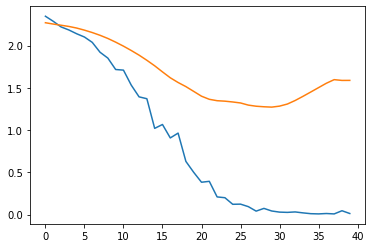

In [42]:
# Partial data overfit:
model = build_model()

hist = model.fit(xtrain[C.ind], ytrain[C.ind],
                  batch_size=1024,
                  epochs=40,
                  verbose=0,
                  validation_data=(xtest, ytest))

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

score = model.evaluate(xtest, ytest, verbose=0)
print('Accuracy: ',score[1])

Accuracy:  0.1044


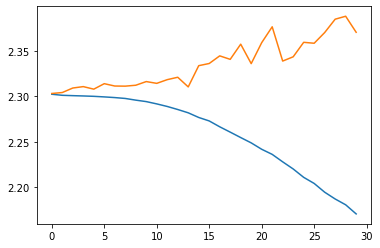

In [60]:
# Pre-training on random data:
model = build_model()

hist = model.fit(xtrain, ytrain[np.random.choice(range(len(ytrain)), size=len(ytrain), replace=False)],
                  batch_size=1024,
                  epochs=30,
                  verbose=0,
                  validation_data=(xtest, ytest))

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

score = model.evaluate(xtest, ytest, verbose=0)
print('Accuracy: ',score[1])

Accuracy:  0.1676


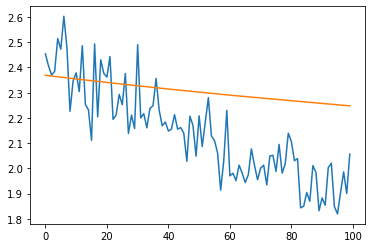

In [61]:
# Now post-train on partial labels

for layer in model.layers[:-1]:
    layer.trainable = False

model.compile(loss='categorical_crossentropy',
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy'])

hist = model.fit(xtrain[C.ind], ytrain[C.ind],
                  batch_size=1024,
                  epochs=100,
                  verbose=0,
                  validation_data=(xtest, ytest))

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

score = model.evaluate(xtest, ytest, verbose=0)
print('Accuracy: ',score[1])